In [17]:
# Load 'df_queries_filtered.csv' into a DataFrame
csv_path = "df_queries_filtered.csv"


# try to find the file if it's not in the current working directory
if not os.path.exists(csv_path):
    matches = glob("**/df_queries_filtered*.csv", recursive=True)
    if matches:
        csv_path = matches[0]
        print(f"Found CSV at: {csv_path}")
    else:
        raise FileNotFoundError(
            f"'{csv_path}' not found in {os.getcwd()}. Place the file there or update csv_path."
        )

# read the CSV (use low_memory=False to avoid dtype inference warnings)
df_queries = pd.read_csv(csv_path, low_memory=False)

# quick inspection
print(f"Loaded '{csv_path}' with shape: {df_queries.shape}")
print(df_queries.head())

Found CSV at: google_exports\df_queries_filtered.csv
Loaded 'google_exports\df_queries_filtered.csv' with shape: (127, 10)
                               query_id                            session_id  \
0  01dfe28b-a6a7-4b30-8a13-43e10bd5d085  1214eecf-5b2a-4675-9926-f06f9619dee8   
1  042b0b64-c626-4449-829a-4dd8d7532af8  1dd3d11a-dec8-4041-b981-8efab9dce7b4   
2  04aa2261-185f-4beb-bb95-ec0993cb08bf  1214eecf-5b2a-4675-9926-f06f9619dee8   
3  0744ba2a-a874-4126-a596-2ccf4c5a1574  ae444d00-9295-437f-812b-f75240800327   
4  07e24f82-f867-4794-afbd-b704031ee17d  21821039-baef-4c67-94ea-4099060a4805   

   query_order                        query_text query_structure  \
0            4                         iphone 15         keyword   
1            1  best smartphones under 400 euros     comparative   
2            3                       samsung s25         keyword   
3            2      eco friendly smartphone 2025         keyword   
4            1                Good quality phone  

In [21]:
# Override embedding helpers to support both openai<1.0 and >=1.0 clients
from typing import List, Union
import numpy as np
import time
import logging
import openai


def embed_texts(texts: Union[str, List[str]], batch_size: int = 128, max_retries: int = 5, backoff_base: float = 1.5) -> np.ndarray:
    """
    Get embeddings for a single string or a list of strings using OpenAI embeddings API.
    Uses new client API when available (openai>=1.0), otherwise falls back to legacy (openai<1.0).
    Returns a NumPy array of shape (n_texts, embedding_dim).
    """
    if isinstance(texts, str):
        texts = [texts]
    texts = [("" if t is None else str(t)) for t in texts]

    embeddings: List[List[float]] = []
    for start in range(0, len(texts), batch_size):
        batch = texts[start:start + batch_size]
        for attempt in range(1, max_retries + 1):
            try:
                # Prefer the new API if available (openai>=1.0 exposes OpenAI)
                if hasattr(openai, "OpenAI"):
                    OpenAIClient = openai.OpenAI
                    try:
                        client = OpenAIClient(api_key=getattr(openai, "api_key", None))
                    except TypeError:
                        client = OpenAIClient()
                    resp = client.embeddings.create(model=EMBEDDING_MODEL, input=batch)
                    batch_emb = []
                    for item in resp.data:
                        if hasattr(item, "embedding"):
                            batch_emb.append(item.embedding)
                        elif isinstance(item, dict) and "embedding" in item:
                            batch_emb.append(item["embedding"])
                        else:
                            raise RuntimeError("Unexpected embeddings response format from OpenAI client.")
                else:
                    # Legacy API path (openai<1.0)
                    resp = openai.Embedding.create(model=EMBEDDING_MODEL, input=batch)
                    batch_emb = [item["embedding"] for item in resp["data"]]
                embeddings.extend(batch_emb)
                break
            except Exception as e:
                if attempt == max_retries:
                    logging.error("Max retries reached for embedding request.")
                    raise
                sleep_time = backoff_base ** attempt
                logging.warning(f"Embedding request failed (attempt {attempt}/{max_retries}): {e}. Retrying in {sleep_time:.1f}s")
                time.sleep(sleep_time)

    return np.array(embeddings, dtype=np.float32)


def embed_series(series: pd.Series, **kwargs) -> np.ndarray:
    """Convenience wrapper to embed a pandas Series of text values using embed_texts above."""
    texts = series.fillna("").astype(str).tolist()
    return embed_texts(texts, **kwargs)

In [37]:
# Build unique example queries per cluster (case-insensitive, normalized)
import numpy as np, pandas as pd, re, matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

def normalize_text(s: str) -> str:
    s = str(s).casefold()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9]+", " ", s)
    return s.strip()

EXAMPLES_PER_CLUSTER = 5

E = np.asarray(embeddings)
E_norm = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-12)

examples_rows = []
closest_point_index = {}
for c in sorted(df_queries["cluster"].unique()):
    idx = df_queries.index[df_queries["cluster"] == c].to_numpy()
    if idx.size == 0:
        continue
    centroid = E_norm[idx].mean(axis=0)
    centroid = centroid / (np.linalg.norm(centroid) + 1e-12)
    sims = (E_norm[idx] @ centroid)
    order = np.argsort(-sims)
    seen_norm = set()
    rank = 0
    for local_i in order:
        gi = int(idx[local_i])
        qtxt = str(df_queries.loc[gi, "query_text"])
        norm = normalize_text(qtxt)
        if not norm or norm in seen_norm:
            continue
        seen_norm.add(norm)
        rank += 1
        examples_rows.append({
            "cluster": int(c),
            "cluster_theme": df_queries.loc[gi, "cluster_theme"],
            "global_index": gi,
            "similarity_to_centroid": float(sims[local_i]),
            "rank": rank,
            "query_text": qtxt,
        })
        if rank == 1:
            closest_point_index[int(c)] = gi
        if rank >= EXAMPLES_PER_CLUSTER:
            break

cluster_examples = pd.DataFrame(examples_rows)
cluster_examples.to_csv("df_queries_cluster_examples.csv", index=False)
print("Saved df_queries_cluster_examples.csv (unique examples)")
for c in sorted(cluster_examples["cluster"].unique()):
    sub = cluster_examples[cluster_examples["cluster"] == c].sort_values("rank")
    label = sub["cluster_theme"].iloc[0]
    print(f"Cluster {c} — {label} (k={len(sub)})")
    for _, r in sub.iterrows():
        print(f"  #{r['rank']}: {r['query_text']}")

Saved df_queries_cluster_examples.csv (unique examples)
Cluster 0 — Samsung / Galaxy S-series (k=5)
  #1: samsung s25
  #2: samsung s25 ultra
  #3: samsung s25 ultra review
  #4: Samsung Galaxy S24 FE buy
  #5: Samsung galaxy s23
Cluster 1 — iPhone models & releases (k=5)
  #1: iphone 15
  #2: iphone 17
  #3: iphone 16
  #4: Apple iphone 17
  #5: Iphone 14
Cluster 2 — Best-of & budget picks (2025) (k=5)
  #1: Best budget smartphones 2025
  #2: Cheap smartphones
  #3: Smartphone
  #4: Best smartphones 2025
  #5: Smartphone 300€
Cluster 3 — Price-targeted queries (k=5)
  #1: smartphones under 799 euro
  #2: buying iphone under 800 euro
  #3: best iphone for under 700 euros
  #4: phone 150 euro
  #5: phone under 800 euro
Cluster 4 — Product comparison and shopping (k=5)
  #1: phones
  #2: fairphone 5
  #3: phone
  #4: fairphone 5 buy
  #5: latest phones


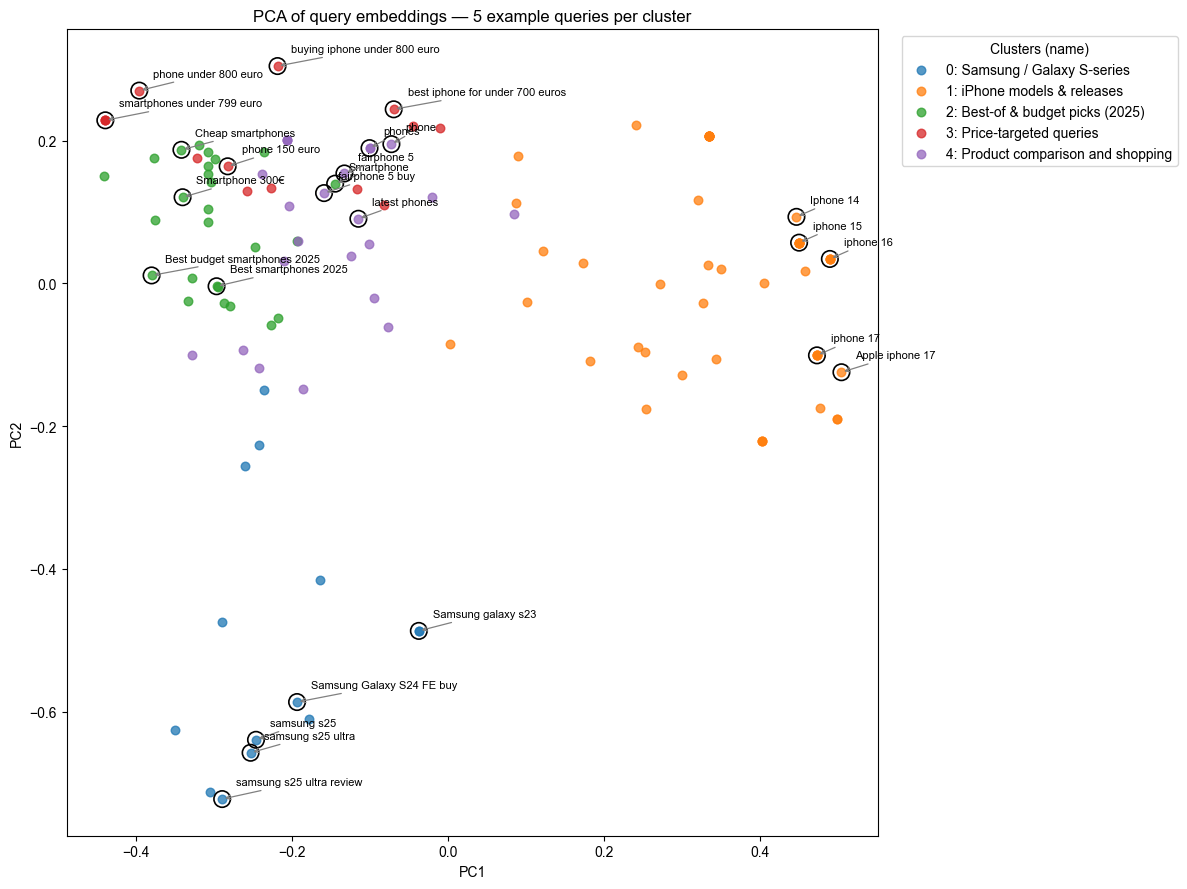

In [38]:
# Plot with 5 example queries annotated per cluster (no cluster names in labels)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re

# Use Arial font for all text
plt.rcParams["font.family"] = "Arial"

def normalize_text(s: str) -> str:
    s = str(s).casefold()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9]+", " ", s)
    return s.strip()

# Ensure embeddings and 2D projection
E = np.asarray(embeddings)
E_norm = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-12)
try:
    emb2
except NameError:
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    emb2 = pca.fit_transform(E_norm)

# Ensure cluster_examples exists (top-K by centroid similarity, unique normalized query_texts)
try:
    cluster_examples
except NameError:
    EXAMPLES_PER_CLUSTER = 5
    examples_rows = []
    for c in sorted(df_queries["cluster"].unique()):
        idx = df_queries.index[df_queries["cluster"] == c].to_numpy()
        if idx.size == 0:
            continue
        centroid = E_norm[idx].mean(axis=0)
        centroid = centroid / (np.linalg.norm(centroid) + 1e-12)
        sims = (E_norm[idx] @ centroid)
        order = np.argsort(-sims)
        seen_norm = set()
        rank = 0
        for local_i in order:
            gi = int(idx[local_i])
            qtxt = str(df_queries.loc[gi, "query_text"])
            norm = normalize_text(qtxt)
            if not norm or norm in seen_norm:
                continue
            seen_norm.add(norm)
            rank += 1
            examples_rows.append({
                "cluster": int(c),
                "global_index": gi,
                "rank": rank,
                "query_text": qtxt,
            })
            if rank >= EXAMPLES_PER_CLUSTER:
                break
    import pandas as pd
    cluster_examples = pd.DataFrame(examples_rows)

# Build color map per cluster
unique_clusters = sorted(df_queries["cluster"].unique())
colors = list(plt.cm.tab10.colors)
cluster_color = {int(c): colors[i % len(colors)] for i, c in enumerate(unique_clusters)}

plt.figure(figsize=(12,9))
# Base scatter with legend using cluster names
for c in unique_clusters:
    mask = (df_queries["cluster"] == c).to_numpy()
    name = str(df_queries.loc[mask, "cluster_theme"].iloc[0]) if np.any(mask) else str(c)
    plt.scatter(
        emb2[mask, 0], emb2[mask, 1],
        s=38, alpha=0.75,
        color=cluster_color[int(c)],
        label=f"{int(c)}: {name}"
    )

# Annotate top-5 examples per cluster with only the query text (unique)
for c in unique_clusters:
    sub = cluster_examples[cluster_examples["cluster"] == int(c)].sort_values("rank").head(5)
    for _, r in sub.iterrows():
        gi = int(r["global_index"])
        x, y = emb2[gi]
        txt = str(df_queries.loc[gi, "query_text"]) if "query_text" in df_queries.columns else ""
        short = (txt[:60] + "…") if len(txt) > 60 else txt
        # ring highlight and text without cluster name and without box
        plt.scatter([x], [y], s=140, facecolors='none', edgecolors='black', linewidths=1.2)
        plt.annotate(
            f"{short}",
            xy=(x, y), xycoords='data',
            xytext=(10, 10), textcoords='offset points',
            fontsize=8,
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.9)
        )

plt.title("PCA of query embeddings — 5 example queries per cluster")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='Clusters (name)', frameon=True)
plt.tight_layout()
plt.show()

In [36]:
pip install openai python-dotenv pandas scikit-learn numpy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
pip install openai python-dotenv pandas scikit-learn numpy